In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ssm

from src.load_data import load_data 

In [25]:
#!pip install src/ssm/ -e .

## Load Data

In [362]:
df = load_data(path='data/CSH_ZAD_019.csv')
df.columns

Index(['Unnamed: 0', 'probabilityLeft', 'feedback_times', 'contrastRight',
       'contrastLeft', 'response_times', 'feedbackType', 'stimOn_times',
       'choice', 'firstMovement_times', 'goCue_times', 'rewardVolume',
       'intervals_0', 'intervals_1', 'session', 'session_start_time',
       'session_number', 'task_protocol'],
      dtype='object')

<Axes: >

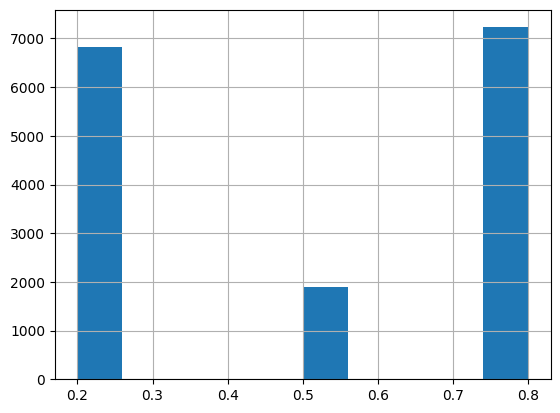

In [363]:
# Filter only July and Agust sessions (full task)
bdf7 = df[df["session_start_time"].str.contains("2020-07")]
bdf8 = df[df["session_start_time"].str.contains("2020-08")] 
bdf = pd.concat([bdf7, bdf8]).sort_index()
bdf.probabilityLeft.hist()

<Axes: >

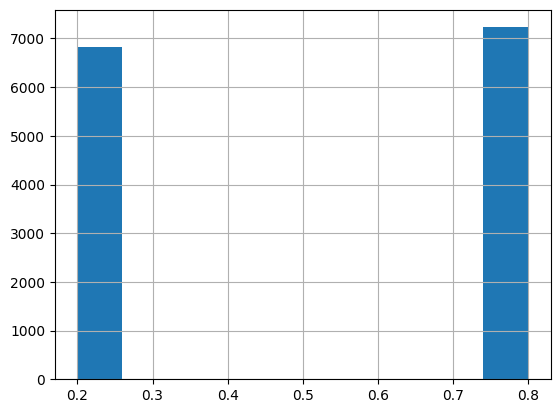

In [364]:
# Filter by probability left
cdf2 = bdf[bdf["probabilityLeft"]==0.2]
cdf8 = bdf[bdf["probabilityLeft"]==0.8]
cdf = pd.concat([cdf2, cdf8]).sort_index()
cdf.probabilityLeft.hist()

In [365]:
len(df.session.unique())
#len(bdf.session.unique())
#len(cdf.session.unique())

77

In [366]:
cdf.session_start_time.unique()

array(['2020-07-14 10:25:12.739113', '2020-08-13 10:32:23.510709',
       '2020-08-19 11:31:40.000000', '2020-08-11 09:35:28.164173',
       '2020-07-09 08:39:39.686985', '2020-08-10 15:29:27.381124',
       '2020-08-16 07:39:40.000000', '2020-08-12 10:13:28.494154',
       '2020-07-08 14:51:44.566364', '2020-08-03 08:28:23.216558',
       '2020-07-17 13:08:44.585041', '2020-07-10 14:30:37.590534',
       '2020-08-04 08:29:51.919526', '2020-07-20 11:58:08.470744',
       '2020-08-07 08:09:22.479575', '2020-07-13 12:54:36.164264',
       '2020-08-14 11:36:42.000000', '2020-07-16 12:55:04.715750',
       '2020-08-18 07:41:02.000000', '2020-07-22 12:29:23.349371',
       '2020-07-21 11:41:20.605764'], dtype=object)

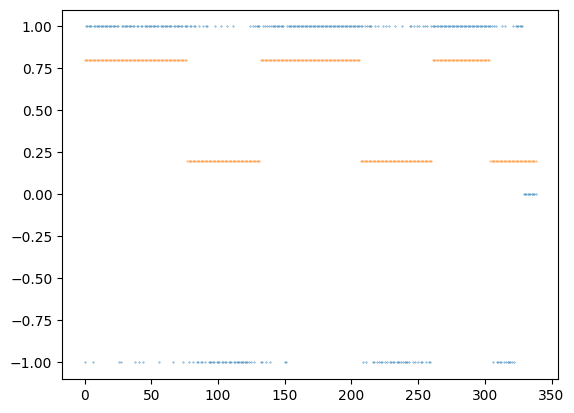

In [139]:
session_id = cdf.session.iloc[10548]
mouseN_df = cdf[cdf["session"]==session_id]
plt.scatter(np.arange(len(mouseN_df["choice"])), mouseN_df["choice"], s=0.09)
plt.scatter(np.arange(len(mouseN_df["probabilityLeft"])), mouseN_df["probabilityLeft"], s=0.09)
plt.show()

## Psychometric Curves

## GLM-HMM

In [137]:
# Set the parameters of the GLM-HMM
num_states = 2        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make a GLM-HMM
true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

# true_hmm = ssm.HMM(num_states, obs_dim, input_dim, 
#                observations="categorical", observation_kwargs=dict(C=num_categories),
#                transitions="inputdriven")

In [141]:
gen_weights = np.array([[[6, 1]], [[2, -3]], [[2, 3]]])
gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01], [0.05, 0.92, 0.03], [0.03, 0.03, 0.94]]]))
true_glmhmm.observations.params = gen_weights
true_glmhmm.transitions.params = gen_log_trans_mat

In [192]:
# External input sequences
num_sess = 20 # number of example sessions
num_trials_per_sess = 100 # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
stim_vals = [-1, -0.5, -0.25, -0.125, -0.0625, 0, 0.0625, 0.125, 0.25, 0.5, 1]
inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
inpts = list(inpts) #convert inpts to correct format

In [193]:
cdf.columns

Index(['Unnamed: 0', 'probabilityLeft', 'feedback_times', 'contrastRight',
       'contrastLeft', 'response_times', 'feedbackType', 'stimOn_times',
       'choice', 'firstMovement_times', 'goCue_times', 'rewardVolume',
       'intervals_0', 'intervals_1', 'session', 'session_start_time',
       'session_number', 'task_protocol'],
      dtype='object')

[0.125     nan 0.25   0.     0.0625 1.    ]
[   nan 0.125  0.0625 0.     0.25   1.    ]


<Axes: >

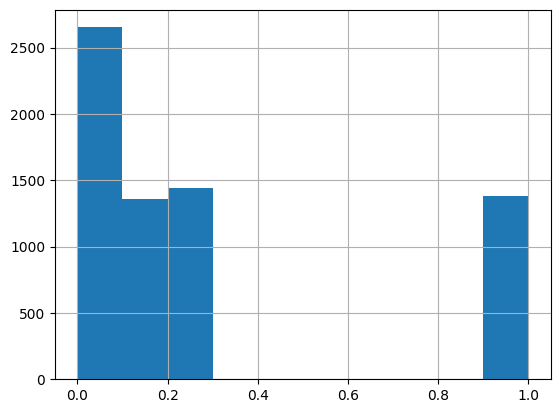

In [216]:
print(cdf.contrastRight.unique() )
print(cdf.contrastLeft.unique() )
cdf.contrastRight.hist()
#cdf[["contrastRight", "contrastLeft"]]

In [248]:
df.probabilityLeft

0        0.5
1        0.9
2        0.5
3        0.5
4        0.5
        ... 
60496    0.5
60497    0.5
60498    0.5
60499    0.5
60500    0.5
Name: probabilityLeft, Length: 60501, dtype: float64

In [380]:
# Get choices as matrix
def get_trials_by_session_matrix(dt, column, trim=True, plot_untrimmed_hist=False):
    grouped = dt.groupby('session')[column]
    untrimmed_choices = [group.values for name, group in grouped]
    if trim:
        min_arr_l = min(len(arr) for arr in untrimmed_choices)
        matrix = [arr[:min_arr_l] for arr in untrimmed_choices]
        #matrix = np.array(matrix)
    else:
        matrix = untrimmed_choices
    if plot_untrimmed_hist:
        lens = []
        for i in range(len(untrimmed_choices)):
            lens.append(len(untrimmed_choices[i]))
        plt.hist(lens)
    return matrix

choices = get_trials_by_session_matrix(cdf, "choice")


# Create external input sequences
inputs = []

# Create contrasts
cdf['mergedContrasts'] = cdf[ "contrastLeft"].fillna(0) - cdf["contrastRight"].fillna(0)

contrasts = cdf.groupby('session')["mergedContrasts"] 
untrimmed_contrasts = [x.values for _, x in contrasts]
contrasts = [arr[:min_arr_l] for arr in untrimmed_contrasts]

contrasts1 = get_trials_by_session_matrix(cdf, "mergedContrasts")

# Create Biases
biases = [np.array([1*min_arr_l])]*len(choices)

# Create previous choice
df5 = bdf[bdf["probabilityLeft"]==0.5]
first_choices = np.array(get_trials_by_session_matrix(df5, "choice", trim=False))[:, -1]
#first_choices = [0]*len(choices)
prev_choices = []
for sess_i, session in enumerate(choices):
    prev_c = np.insert(session, 0, first_choices[sess_i]) # new first choice from 50:50
    prev_c = prev_c[:-1]
    prev_choices.append(prev_c)

# Win-stay-loose-switch
df5["rewards"] = df5["rewardVolume"].replace(0.0, -1).replace(1.5, 1)
first_rewards = np.array(get_trials_by_session_matrix(df5, "rewards", trim=False))[:, -1]
cdf["rewards"] = cdf["rewardVolume"].replace(0.0, -1).replace(1.5, 1)
rewards = get_trials_by_session_matrix(cdf, "rewards")

prev_rewards = []
ws_ls = []
for rew_i, rew in enumerate(rewards):
    prev_r = np.insert(rew, 0, first_rewards[rew_i]) # new first reward from 50:50
    prev_r = prev_r[:-1]
    prev_rewards.append(prev_r)

    ws_ls.append(prev_r * choices[rew_i])



/tmp/ipykernel_957/119041309.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5["rewards"] = df5["rewardVolume"].replace(0.0, -1).replace(1.5, 1)


In [146]:



new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(cdf["choice"], inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

IndexError: tuple index out of range